In [101]:
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from scipy.interpolate import CubicSpline
from matplotlib.cm import get_cmap

from _analysis_functions import format_cols, load_and_combine_dfs, filter_for_classes

plt.rcParams.update({'font.size': 14})

In [2]:
model = torch.load("/home/oliver/PycharmProjects/NeuralStyle/models/predictors/wrn_mnist_2.pkl")

In [3]:
data = datasets.MNIST(root="data/", train=False, download=False)
test_labels = data.targets
transform = transforms.Compose(
            [
                transforms.Pad(2),
                transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
            ]
        )
test_data = np.array([transform(d) for d in data.data])

/home/oliver/miniconda3/envs/neuralstyle/lib/python3.9/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /tmp/pip-req-build-lzws6sq3/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
/tmp/ipykernel_1052270/3179792284.py:9: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the o

In [4]:
def _pred(x):
    x = torch.tensor(x).unsqueeze(0).float() if not isinstance(x, torch.Tensor) else x.unsqueeze(0).float()
    pred = model(x.cuda()).squeeze(0).cpu().detach().numpy()
    return pred

In [5]:
df1 = format_cols(pd.read_csv("results/results_lmt_MNIST_wrn_sg2_ubtgn.csv"), reduce_channels=False)
df2 = format_cols(load_and_combine_dfs(path="/home/oliver/NSExperimentation/", filters=["sinvad", "mnist"]), reduce_channels=False)
df3 = format_cols(load_and_combine_dfs(path="/home/oliver/NSExperimentation/", filters=["DeepJanus", "MNIST"]), reduce_channels=False)

In [6]:
df2["X_prime"] = df2["X_prime"].apply(lambda x: np.repeat(np.expand_dims(np.pad(x, ((2,2), (2,2)), mode="constant", constant_values=0), 0), 3, axis=0))
df2["X"] = df2["X"].apply(lambda x: np.repeat(np.expand_dims(np.pad(x, ((2,2), (2,2)), mode="constant", constant_values=0), 0), 3, axis=0))

df3["X_prime"] = df3["X_prime_1"]

In [7]:
dfs = [df1, df2, df3]

In [8]:
for df in dfs:
    df["pred"] = df["X_prime"].apply(lambda x: _pred(x))
    df["pred_o"] = df["X"].apply(lambda x: _pred(x))

In [9]:
ds_pred = [_pred(x/255) for x in test_data]

In [10]:
all_comb, lens = ds_pred, [0, len(ds_pred)]

for df in dfs:
    all_comb += df["pred"].to_list() + df["pred_o"].to_list()
    lens += [len(df)]*2

In [11]:
pca = PCA(n_components=2)

In [12]:
emb = pca.fit_transform(all_comb)
embs = [emb[sum(lens[:i+1]): sum(lens[:i+2])] for i in range(len(lens))]

In [13]:
emb_ds = embs[0]
emb_smoo, emb_o_smoo = embs[1:3]
emb_sinv, emb_o_sinv = embs[3:5]
emb_dj, emb_o_dj = embs[5:7]

In [14]:
classes = [6,5]
smoo_pred = df1["y_prime"]
emb_ds_f, cl_ds = filter_for_classes(emb_ds, class_information=pd.Series(test_labels.numpy()), classes=classes)
emb_smoo_f, emb_o_smoo_f, yp_smoo_f, cl_smoo = filter_for_classes(emb_smoo, emb_o_smoo, smoo_pred, class_information=df1["y"].apply(np.argmax),classes=classes)
emb_sinv_f, emb_o_sinv_f, cl_sinv = filter_for_classes(emb_sinv, emb_o_sinv, class_information=df2["y"].apply(np.argmax),classes=classes)
emb_dj_f, emb_o_dj_f, cl_dj = filter_for_classes(emb_dj, emb_o_dj, class_information=df3["y"].apply(np.argmax),classes=classes)

In [15]:
smoo_bd_f = yp_smoo_f.apply(lambda x: np.argsort(x)[::-1][:2])
smoo_bd_f = [next(x for x in lst if x != val) for lst, val in zip(smoo_bd_f.to_list(), cl_smoo.to_list())]



In [16]:
clf = SVC(kernel="rbf", probability=True, gamma="auto")
clf.fit(emb_ds_f, cl_ds)

SVC(gamma='auto', probability=True)

In [17]:
xx, yy = np.meshgrid(np.linspace(emb_ds_f[:, 0].min() - 1, emb_ds_f[:, 0].max() + 1, 500),
                     np.linspace(emb_ds_f[:, 1].min() - 1, emb_ds_f[:, 1].max() + 1, 500))
grid = np.c_[xx.ravel(), yy.ravel()]

probs = clf.predict_proba(grid)[:, 1]
probs = probs.reshape(xx.shape)

In [18]:
x_order = emb_smoo_f[:,0].argsort()
x,y = emb_smoo_f[:,0][x_order], emb_smoo_f[:,1][x_order]
spline = CubicSpline(x,y)

x_fit = np.linspace(min(x), max(x), 100)
y_fit = spline(x_fit)

In [19]:
sel_o, sel, sel_bd = emb_o_smoo_f, emb_smoo_f, np.array(smoo_bd_f)

In [20]:
# Only select pairs that have boundaries between the two classes
cond = [False]* len(sel_o)
for i in classes:
    cond += sel_bd == i

sel_o = sel_o[cond]
sel = sel[cond]
sel_bd = sel_bd[cond]

In [21]:
ds_probs = clf.predict_proba(emb_ds_f)[:, 1]
sel_o_probs = clf.predict_proba(sel_o)[:, 1]
sel_probs = clf.predict_proba(sel)[:, 1]

In [103]:
def plot_manifold(d3: bool):
    fig = plt.figure(figsize=(8, 8))
    if d3:
        ax = fig.add_subplot(111, projection='3d')
    else:
        ax = fig.add_subplot(111)
    cmap = get_cmap('coolwarm')

    o = [sel_o[:,0], sel_o[:,1],sel_o_probs] if d3 else [sel_o[:,0], sel_o[:,1]]  # Origin points
    t = [sel[:,0], sel[:,1], sel_probs] if d3 else [sel[:,0], sel[:,1]]  # Target points
    ds = [emb_ds_f[:,0], emb_ds_f[:,1], ds_probs] if d3 else [emb_ds_f[:,0], emb_ds_f[:,1]]  # Dataset points

    if d3:
        ax.plot_surface(xx, yy, probs, cmap=cmap, alpha=0.25, edgecolor='none')
    else:
        filtered = probs.copy()
        mask = (filtered  >= filtered.mean()-0.05) & (filtered <= filtered.mean()+0.05)
        filtered[mask] = -1
        filtered = np.ma.masked_where(filtered == -1, filtered)

        ax.contourf(xx, yy, filtered, cmap=cmap, alpha=0.25, edgecolor='none')


    ax.scatter(*ds, alpha=0.5, c=(cl_ds-min(classes))/(max(classes)-min(classes)), cmap=cmap)

    for source,sz, target,tz, b in zip(sel_o,sel_o_probs, sel,sel_probs, sel_bd):
        src, trg = np.append(source, sz), np.append(target, tz)
        arrow = list(zip(src,trg))

        if d3:
            ax.plot(*arrow, color="black", linewidth=2)
        else:
            dir = tuple(map(lambda i, j: (i - j)*0.95, target, source))
            ax.arrow(*source, *dir, head_width=0.5, head_length=0.25,)

    ax.scatter(*o, marker="o", s=100, c=(cl_smoo[cond]-min(classes))/(max(classes)-min(classes)), cmap=cmap, linewidths=1, edgecolors="black")
    ax.scatter(*t, c=(sel_bd-min(classes))/(max(classes)-min(classes)), cmap=cmap, marker="o", s=100, linewidths=1, edgecolors="black")

    ax.set_yticks([])
    ax.set_xticks([])


    ax.scatter([],[], color=cmap(0), label=5, linewidths=1, edgecolors="black")
    ax.scatter([],[], color="red", label=6, linewidths=1, edgecolors="black")
    ax.legend()

    if d3:
        ax.view_init(elev=30, azim=70)
    plt.savefig(f"figures/boundary_manifold_{'-'.join([str(x) for x in classes])}.svg", bbox_inches="tight")

/tmp/ipykernel_1052270/1123505305.py:21: UserWarning: The following kwargs were not used by contour: 'edgecolor'
  ax.contourf(xx, yy, filtered, cmap=cmap, alpha=0.25, edgecolor='none')


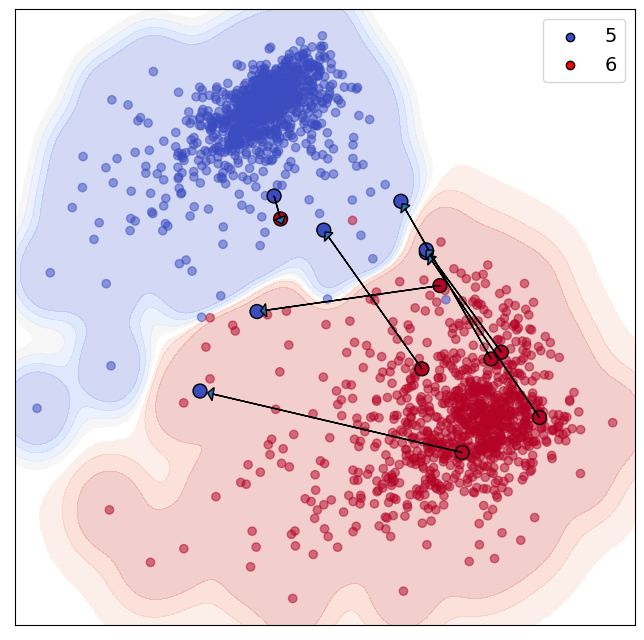

In [104]:
plot_manifold(False)